# Visualize the results on synthetic PIV images
- Optical Flow in Exp4-1, and Cross Correlation in Exp4-2

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from flow import uniform, solid_rot, lamb_oseen, sin_flow
from pig import config, gen_piv_pair, AttrDict
from metrics import PIVmetric, EPE

from deformpiv import DeformPIV
from fdi2cdi import fdi2cdi

# from raft import raft_estimator

np.random.seed(202407)

In [2]:
# Test the performance on the synthetic images
def exp_one(img1,img2, Vs, vmax=0.1):
    def estimate(img1, img2, deform="CDI", pivmethod="crosscorrelation"):
        config = AttrDict()
        config.pivmethod = pivmethod # ['crosscorrelation', 'opticalflow', 'raft_estimator']
        config.deform = deform # ['FDI', 'CDI', 'CDDI', 'FDDI']
        config.runs = 6
        
        piv = DeformPIV(config)
        # x, y, u, v = piv.compute(img1, img2, np.float32(Vs[0][1]), np.float32(Vs[0][0]))
        img1, img2 = cv2.blur(img1, (3,3)), cv2.blur(img2, (3,3)) 
        x, y, u, v = piv.compute(img1, img2)
        return x,y,v,u

    def plot_vectors(epe, u, v, vmin=0, vmax=0.1):
        plt.imshow(epe, vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.quiver(x[8::16,8::16],y[8::16,8::16],u[8::16,8::16],-v[8::16,8::16])
        plt.axis('off')
        
    plt.figure(figsize=(5,2.5))
    plt.subplot(121); plt.imshow(img1);plt.axis("off"); plt.title("Image 1");
    plt.subplot(122); plt.imshow(img2);plt.axis("off"); plt.title("Image 2");
    
    
    x, y, u_fdi, v_fdi = estimate(img1, img2, deform="FDI")
    x, y, u_cdi, v_cdi = estimate(img1, img2, deform="CDI")
    # x, y, u_raft, v_raft = raft_estimator(img1, img2)
    u_fdi2cdi,v_fdi2cdi = fdi2cdi(u_fdi,v_fdi, t=0, delta=1)

    # Remove the boundary with width 10
    u_fdi, v_fdi = u_fdi[10:-10,10:-10], v_fdi[10:-10,10:-10] 
    u_cdi, v_cdi = u_cdi[10:-10,10:-10], v_cdi[10:-10,10:-10]
    u_fdi2cdi, v_fdi2cdi = u_fdi2cdi[10:-10,10:-10], v_fdi2cdi[10:-10,10:-10]
    u_t, v_t = Vs[0][0][10:-10,10:-10], Vs[0][1][10:-10,10:-10]

    x, y = np.meshgrid(np.arange(u_t.shape[0]), np.arange(u_t.shape[1]), indexing='xy')
    names = ["FDI (CC)", "CDI (CC)", "FDI2CDI (CC)"]    
    for k, (u, v) in enumerate([(u_fdi, v_fdi), (u_cdi,v_cdi),(u_fdi2cdi,v_fdi2cdi)]):
        epe = EPE(u_t, v_t, u, v)
        plt.figure(figsize=(3.5,2.8))
        plot_vectors(epe, u, v, vmax=vmax)
        plt.savefig(f"output/Fig11_case{case}_{names[k]}.pdf")
        plt.title(names[k])

        print(names[k])
        PIVmetric(u_t,v_t,u,v)

FDI (CC)
0.0357(RMSE)	0.0339(AEE)	0.0019(AAE,rad)	0.9993(SSIM)	0.9935(MoC)	0(Outlier)	
CDI (CC)
0.0691(RMSE)	0.0679(AEE)	0.0058(AAE,rad)	0.9992(SSIM)	0.9874(MoC)	0(Outlier)	
FDI2CDI (CC)
0.0355(RMSE)	0.0338(AEE)	0.0019(AAE,rad)	0.9994(SSIM)	0.9935(MoC)	0(Outlier)	


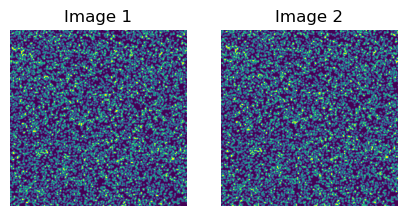

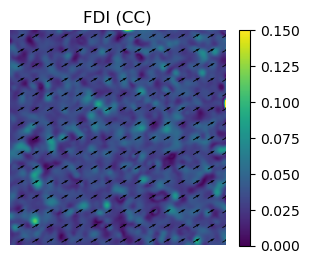

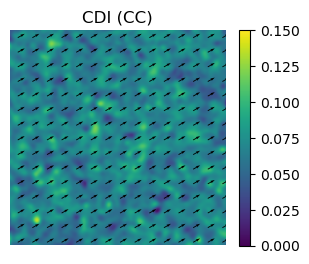

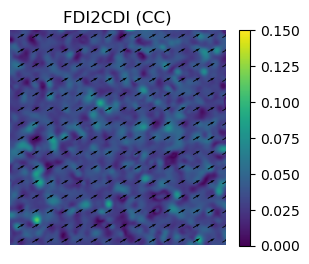

In [3]:
def flow(x,y):
    return uniform(x, y, uc=4.2, vc=-2.4)

def clipx(imgs, VS):
    imgs_ = imgs[0][25:-25,25:-25], imgs[1][25:-25,25:-25]
    Vs0_ = (VS[0][0][25:-25,25:-25], VS[0][1][25:-25,25:-25])
    Vs1_ = (VS[1][0][25:-25,25:-25], VS[1][1][25:-25,25:-25])
    Vs2_ = (VS[2][0][25:-25,25:-25], VS[2][1][25:-25,25:-25])
    Vs_ = (Vs0_, Vs1_, Vs2_)
    return imgs_, Vs_

cfg = config()
cfg.flow = flow
imgs, Vs = gen_piv_pair(cfg)
imgs, Vs = clipx(imgs,Vs)
img1, img2 = imgs[0], imgs[1]

case = 0
exp_one(img1, img2, Vs, vmax=0.15)

FDI (CC)
0.1470(RMSE)	0.1213(AEE)	0.0258(AAE,rad)	0.9889(SSIM)	1.0000(MoC)	20(Outlier)	
CDI (CC)
0.0701(RMSE)	0.0635(AEE)	0.0116(AAE,rad)	0.9969(SSIM)	1.0013(MoC)	0(Outlier)	
FDI2CDI (CC)
0.0515(RMSE)	0.0476(AEE)	0.0089(AAE,rad)	0.9977(SSIM)	1.0002(MoC)	0(Outlier)	


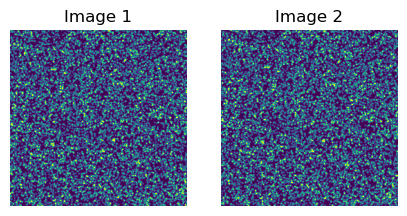

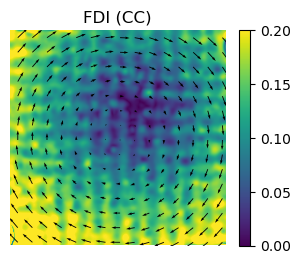

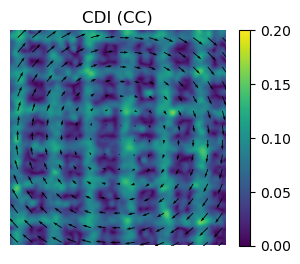

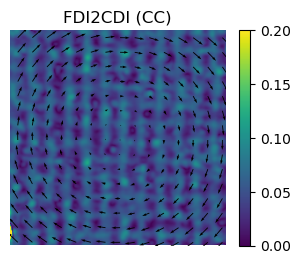

In [4]:
def flow(x,y):
    return solid_rot(x, y, omega=0.05)

cfg = config()
cfg.flow = flow
imgs, Vs = gen_piv_pair(cfg)
imgs, Vs = clipx(imgs,Vs)
img1, img2 = imgs[0], imgs[1]

case = 1
exp_one(img1, img2, Vs, vmax=0.2)

FDI (CC)
0.2220(RMSE)	0.1983(AEE)	0.0360(AAE,rad)	0.9737(SSIM)	0.9973(MoC)	0(Outlier)	
CDI (CC)
0.0770(RMSE)	0.0686(AEE)	0.0100(AAE,rad)	0.9964(SSIM)	0.9992(MoC)	0(Outlier)	
FDI2CDI (CC)
0.0635(RMSE)	0.0555(AEE)	0.0086(AAE,rad)	0.9970(SSIM)	0.9980(MoC)	0(Outlier)	


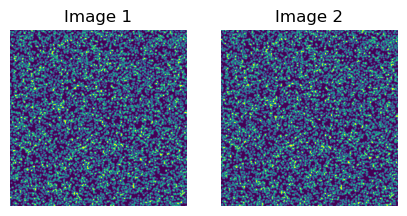

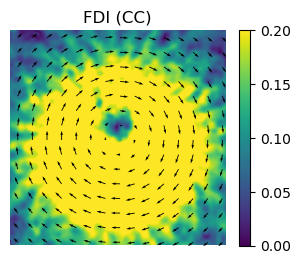

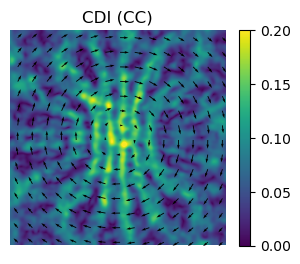

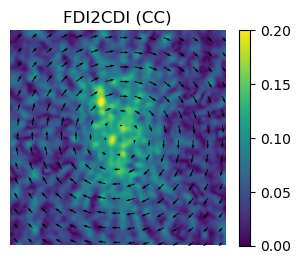

In [5]:
def flow(x,y):
    return lamb_oseen(x, y, Gamma=4e3, rc=64)

cfg = config()
cfg.flow = flow
imgs, Vs = gen_piv_pair(cfg)
imgs, Vs = clipx(imgs,Vs)
img1, img2 = imgs[0], imgs[1]

case = 2
exp_one(img1, img2, Vs, vmax=0.2)

FDI (CC)
0.1238(RMSE)	0.0982(AEE)	0.0157(AAE,rad)	0.9575(SSIM)	1.0016(MoC)	17(Outlier)	
CDI (CC)
0.0693(RMSE)	0.0606(AEE)	0.0088(AAE,rad)	0.9827(SSIM)	1.0020(MoC)	0(Outlier)	
FDI2CDI (CC)
0.0645(RMSE)	0.0589(AEE)	0.0093(AAE,rad)	0.9822(SSIM)	1.0015(MoC)	0(Outlier)	


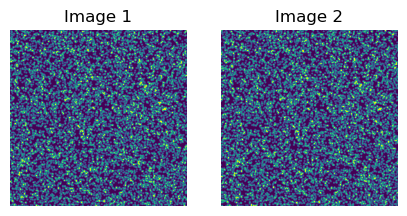

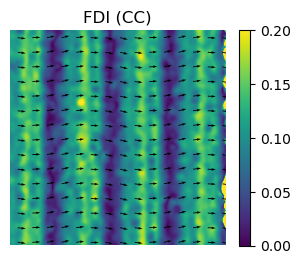

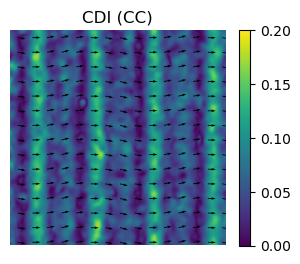

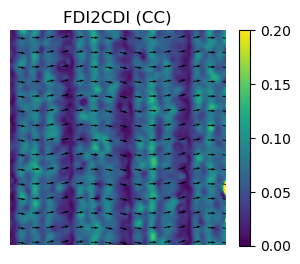

In [6]:
def flow(x,y):
    return sin_flow(x, y, a=5, b=128, scale=6)

cfg = config()
cfg.flow = flow
imgs, Vs = gen_piv_pair(cfg)
imgs, Vs = clipx(imgs,Vs)
img1, img2 = imgs[0], imgs[1]

case = 3
exp_one(img1, img2, Vs, vmax=0.2)